# **Analyzing the Impact of Smoothing Factor on KAN-PIN for the Marmousi Velocity Model**  

In this notebook, we investigate how the smoothing factor influences the quality of the model, balancing between precision and fidelity to the velocity model.

## **Setup**

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import random
import math
from typing import Tuple, Optional
from functools import partial
from itertools import cycle, product
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import plotly.graph_objects as go

from tqdm.auto import tqdm
import enlighten
from kan import KAN

import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Sampler
from utils.architecture import Architecture
from rt_python import DataGeneratorMarmousi
from utils.metrics import score

SEED = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Use CUDA device when available. Otherwise, use CPU device.

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = 'cpu'  # Force CPU usage
print(f"Using '{DEVICE}' device.")

Using 'cpu' device.


Setup your path to data, output and checkpoint folders. 

In [3]:
DATA_PATH = Path("./data/test_smooth_factor")
OUTPUT_PATH = Path("./output/test_smooth_factor")
CHECKPOINT_PATH = OUTPUT_PATH/"model"

In [6]:
factor_list = [20, 25, 30, 35, 40]

## **Data Acquisition**

The dataset used in this study is derived from the Marmousi velocity model, a well-known synthetic benchmark in geophysics. This model represents a highly complex subsurface with strong velocity variations, making it ideal for testing ray-tracing algorithms and machine-learning approaches in seismic imaging.

To improve numerical stability and facilitate more efficient training, we normalize the velocity values by converting them to **km/s**. This transformation mitigates scale discrepancies (e.g., values ranging from 10 to 10,000), ensuring better gradient propagation and more stable optimization during model training.

In [70]:
# Model parameters
nx = 2301  # Number of samples in the distance dimension
nz = 751   # Number of samples in the depth dimension
dz = 4     # Distance increment (m)
dx = 4     # Depth increment (m)

# Model limits in km
xmax = nx * dx / 1000
zmax = nz * dz / 1000

vp_file = "data/marmousi_vp.bin"

vp = np.fromfile(vp_file, dtype=np.dtype('float32').newbyteorder('<'))
vp = vp.reshape((nx, nz)).transpose() / 1000  # Converting to km/s
vp.shape

(751, 2301)

Visualizing the Marmousi Velocity Model with Matplotlib

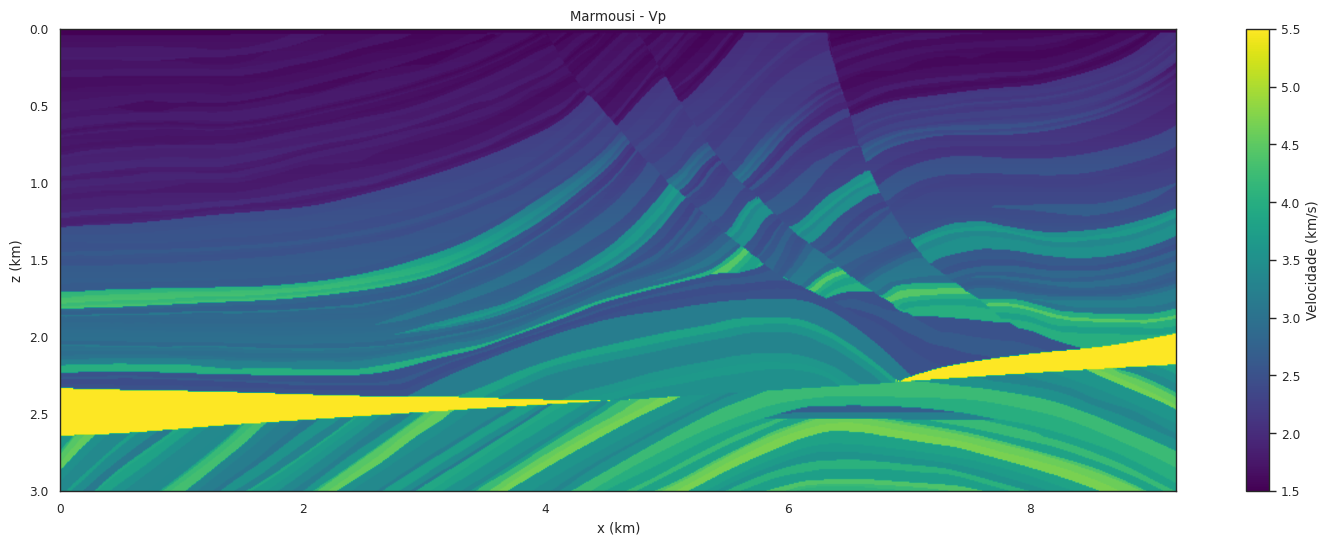

In [71]:
plt.figure(figsize=(18, 6))
plt.imshow(vp, extent=[0, xmax, zmax, 0], aspect='auto', cmap='viridis')
plt.colorbar(label="Velocidade (km/s)")
plt.title("Marmousi - Vp")
plt.xlabel("x (km)")
plt.ylabel("z (km)")
plt.show()

### **Ray-Tracing Data Generation and Visualization Using `DataGeneratorMarmousi`**

The **`DataGeneratorMarmousi`** class systematically generates ray-tracing data within the **Marmousi velocity model**, enabling machine learning-driven approaches in seismic modeling. By leveraging B-spline interpolation and numerical integration, it constructs high-quality training datasets that capture wave propagation dynamics. The class extends `DataGenerator`, inheriting core spatial attributes without redefining the constructor. Its key method, `run_multiple`, generates ray trajectories across a predefined range of initial positions $(x_0, z_0)$ and angles $(\theta_0)$, ensuring comprehensive sampling of the velocity model. This process involves interpolating the velocity field for smooth representation, numerically solving ray equations, and aggregating the computed paths into a structured **DataFrame**. The resulting dataset is optimized for training **Kolmogorov-Arnold Networks (KANs)** and other ML models, providing a physics-informed foundation for learning seismic wave behavior while maintaining computational efficiency.  

The code below initializes an instance of `DataGeneratorMarmousi` and generates a dataset of ray-tracing paths within the **Marmousi velocity model**. The process consists of three main steps:  

1. **Defining the Spatial Domain**:  
   The `x_range` and `z_range` parameters define the horizontal and depth extents of the velocity model, ranging from $0$ to `xmax` and $0$ to `zmax`, respectively. These boundaries ensure that rays are traced within the predefined seismic model.  

2. **Generating Ray-Tracing Data (`run_multiple`)**:  
   The method `run_multiple` is called to compute multiple ray trajectories, systematically sampling different initial conditions:
   - **`x0_range=(4, 6)` and `z0_range=(1, 2)`**: Specifies that rays originate from positions within these spatial bounds.  
   - **`theta_range=(45, 75)`**: Defines the range of initial propagation angles in degrees.  
   - **`vp=vp`**: Passes the Marmousi velocity model as input.  
   - **`factor=30`**: Controls the downsampling of the velocity field for computational efficiency.  
   - **`dx_dy=0.1`**: Sets the resolution for sampling initial positions.  

   The method iterates over all combinations of $(x_0, z_0, \theta_0)$, computes the corresponding ray trajectories, and stores the results in a structured **DataFrame** (`df`). This dataset includes the spatial evolution of each ray over time, along with its velocity and direction of propagation.  

3. **Visualization (`plot`)**:  
   The `plot` method visualizes the generated ray paths overlaid on the velocity model. The **velocity field** is represented as a colormap, while the **ray trajectories** illustrate how seismic waves travel through the subsurface. The figure size `(22,6)` ensures clarity, and `plt.show()` displays the plot.  



This workflow effectively generates a diverse dataset for training **Kolmogorov-Arnold Networks (KANs)** to learn ray tracing patterns while maintaining physical consistency.

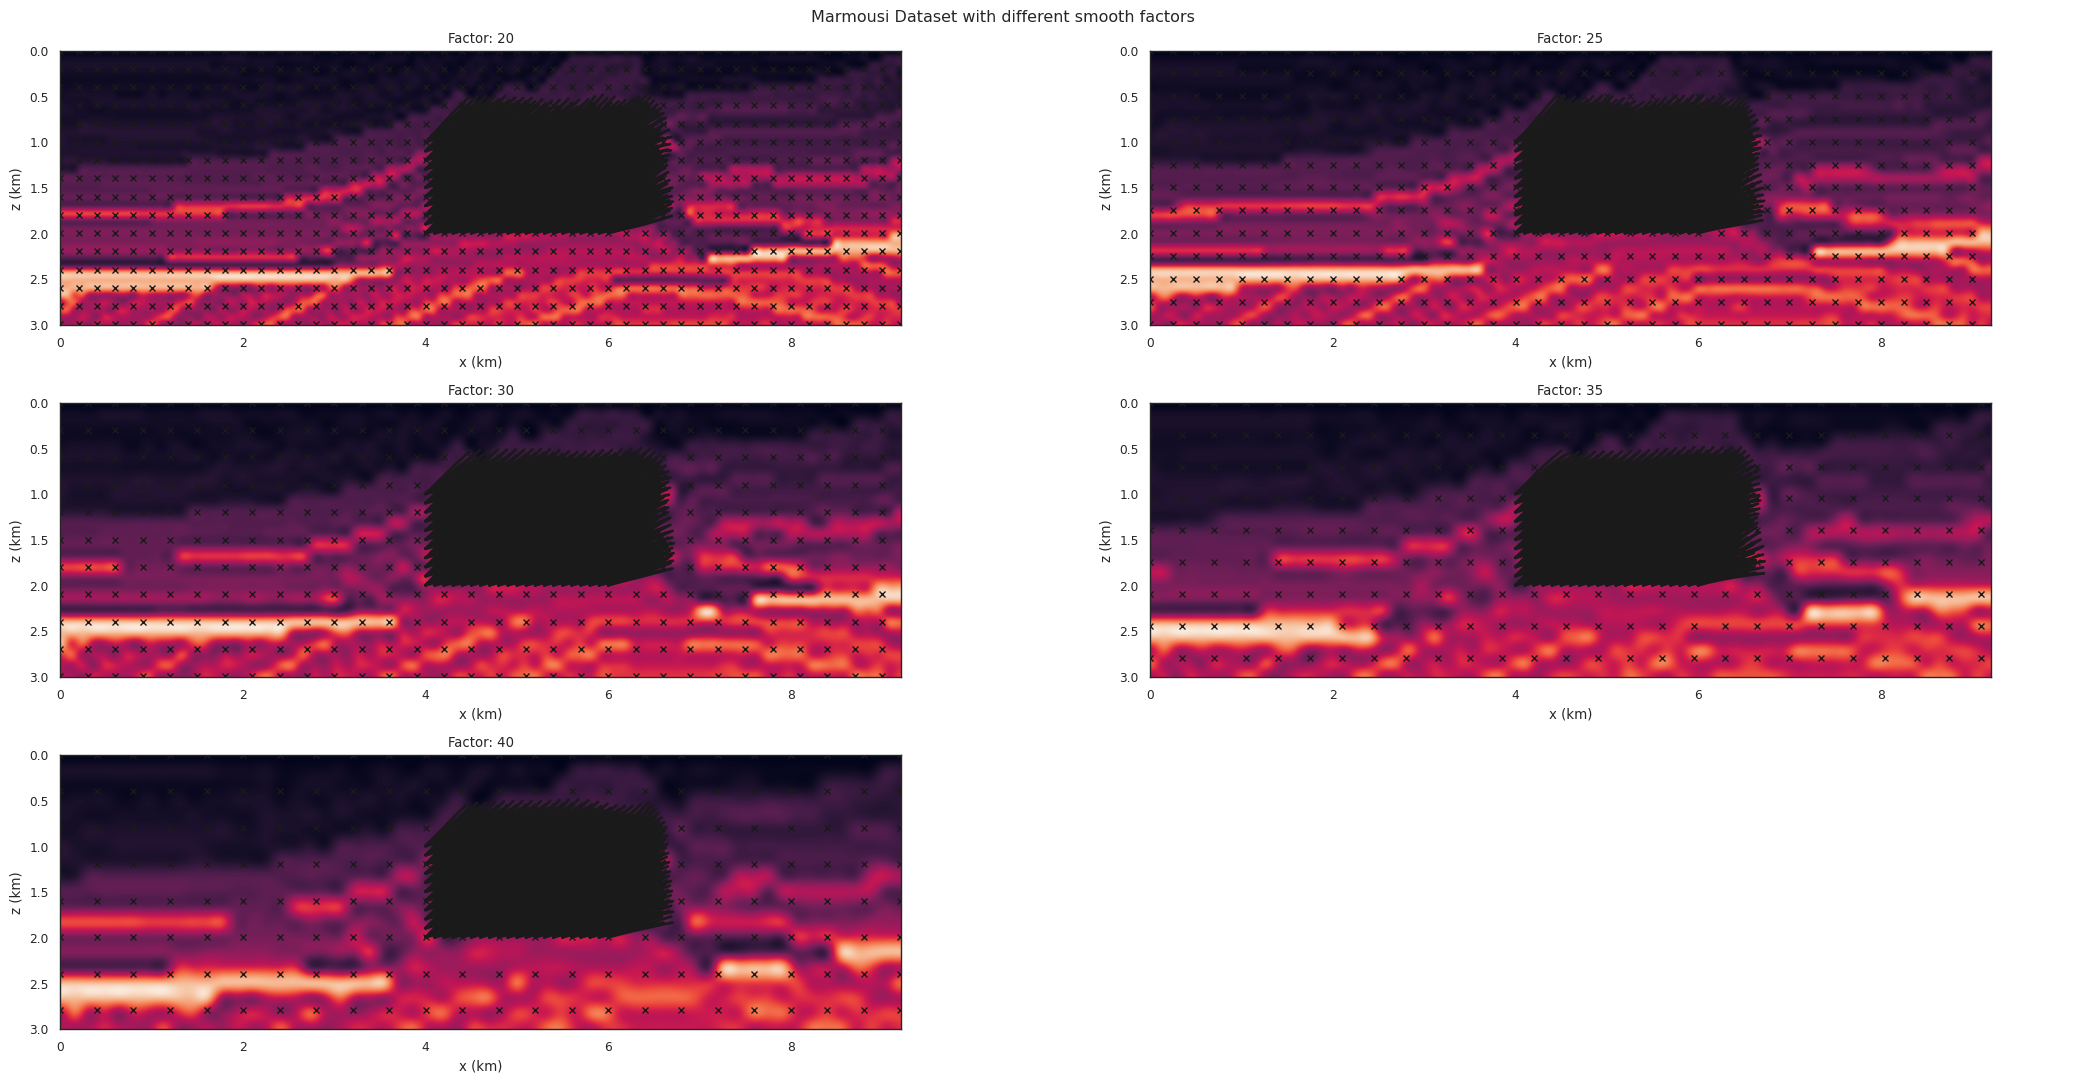

In [72]:
x_range = (0, xmax)
z_range = (0, zmax)

data_dict = {}  # {factor: {'data': dataframe, 'data_gen': data_gen}}
manager = enlighten.get_manager()
pbar = manager.counter(total=len(factor_list), desc="Generating data", units="datasets")

for factor in factor_list:
    data_gen = DataGeneratorMarmousi(
            x_range=x_range,
            z_range=z_range
        )
    df = data_gen.run_multiple(x0_range=(4, 6),
                            z0_range=(1, 2),
                            theta_range=(45, 75),
                            vp=vp,
                            factor=factor,
                            dx_dy=0.1,
                            desc=f"Generating data for {factor=}",
                            manager=manager
                            )
    data_dict[factor] = {
            'data': df,
            'data_gen': data_gen
        }
    
    pbar.update()
manager.stop()

fig, axs = plt.subplots(3, 2, figsize=(22, 11))
    
for factor, ax in zip(factor_list, axs.flatten()):
    data_dict[factor]['data_gen'].plot(data_dict[factor]['data'], ax=ax)
    ax.set_title(f"Factor: {factor}")
    
plt.suptitle("Marmousi Dataset with different smooth factors")

axs[-1, -1].axis('off')
plt.tight_layout()
plt.show()

Here, we define the feature groups for our architecture: **KAN features** (inputs to the Kolmogorov-Arnold Network), **Arch features** (KAN features plus additional features used in the PIN module), and **target features** (the predicted output). This organization ensures a clear and structured data flow within the model.

In [20]:
kan_features = ['x0', 'z0', 'theta0_p', 't']
arch_features = kan_features + ['pi_weight', 'dxdt', 'dzdt', 'dpxdt', 'dpzdt']
target = ['x', 'z', 'px', 'pz']

### **Weights in PINN Loss Function**  

In **Physics-Informed Neural Networks (PINNs)**, loss weighting plays a crucial role in balancing data-driven learning with physical constraints. The weights used in the PINN loss function dynamically adjust the contribution of data and physics-based constraints. In regions with dense data points, the model prioritizes data fidelity, while in sparsely sampled areas, it emphasizes adherence to the governing equations. This adaptive weighting ensures a balanced learning process, improving generalization across the entire domain.  

Here, the **weighting strategy is based on spatial frequency**. The code computes the number of data points within predefined spatial regions (squares), assigning higher weights to underrepresented areas and lower weights to densely populated regions. This **adaptive weighting** prevents the model from overfitting high-density regions and helps it generalize across the entire domain.  

By incorporating these weights into the PINN loss function, the model effectively learns from both observed data and physics-based constraints, leading to improved stability, accuracy, and robustness in solving inverse problems in seismic modeling.

In [8]:
def get_squares_limits(data: pd.DataFrame, restrictions: dict, step: float) -> np.ndarray:
    """
    Generates a set of square limits based on specified feature restrictions and step size.

    This function partitions the feature space into discrete intervals based on given restrictions,
    creating a grid of square regions for further analysis.

    Args:
        data (pd.DataFrame): The input dataset containing feature columns.
        restrictions (dict): A dictionary defining the range of each feature. 
            Each key corresponds to a feature name, and its value is a dictionary 
            with 'min' and 'max' keys specifying the range.
        step (float): The step size used to discretize the feature space.

    Returns:
        np.ndarray: A NumPy array containing all possible square intervals formed by the 
        specified feature restrictions.
    
    Raises:
        AssertionError: If any feature in `restrictions` is not present in the dataset.

    Example:
        >>> data = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})
        >>> restrictions = {'x': {'min': 0, 'max': 3}, 'y': {'min': 4, 'max': 6}}
        >>> get_squares_limits(data, restrictions, step=1)
        array([[[0., 1.], [4., 5.]],
               [[0., 1.], [5., 6.]],
               [[1., 2.], [4., 5.]],
               [[1., 2.], [5., 6.]],
               [[2., 3.], [4., 5.]],
               [[2., 3.], [5., 6.]]], dtype=float32)
    """
    assert all([feature in data.columns for feature in restrictions.keys()]), \
        "Some features presented in restrictions are not in the data."

    # Generate the intervals for each feature
    limits_map = {}
    for name, boundary in restrictions.items():
        aux = np.arange(boundary['min'], boundary['max'] + step, step=step, dtype='float32')
        aux = [round(x, 3) for x in aux]
        limits_map[name] = [(aux[i], aux[i+1]) for i in range(len(aux) - 1)]

    # Create all combinations of the intervals between features
    combinations = list(product(*limits_map.values()))

    result = [np.array(combination, dtype='float32') for combination in combinations]

    return np.array(result, dtype='float32')

In [9]:
def get_frequency(data: pd.DataFrame, restrictions: dict, step: float = 0.1) -> pd.DataFrame:
    """
    Computes the frequency of data points within predefined square regions in the feature space.

    This function divides the input data into grid-based square regions and counts the number 
    of data points falling within each region. The result is stored in a DataFrame.

    Args:
        data (pd.DataFrame): The dataset containing the features to be analyzed.
        restrictions (dict): A dictionary defining feature-wise range restrictions.
            Each key corresponds to a feature name, with 'min' and 'max' specifying the range.
        step (float, optional): The step size used to define square regions. Default is 0.1.

    Returns:
        pd.DataFrame: A DataFrame containing each square's limits and the corresponding data point count.

    Example:
        >>> data = pd.DataFrame({'x': [0.5, 1.5, 2.5], 'y': [4.5, 5.5, 6.5]})
        >>> restrictions = {'x': {'min': 0, 'max': 3}, 'y': {'min': 4, 'max': 6}}
        >>> get_frequency(data, restrictions, step=1)
           square   frequency
        0  [[0, 1], [4, 5]]  1
        1  [[0, 1], [5, 6]]  0
        2  [[1, 2], [4, 5]]  0
        3  [[1, 2], [5, 6]]  1
        4  [[2, 3], [4, 5]]  0
        5  [[2, 3], [5, 6]]  1
    """
    squares_limits = get_squares_limits(data, restrictions, step)

    # Count points in each square
    frequencies = []
    for square in squares_limits:
        mask = np.ones(len(data), dtype=bool)
        for feature, limits in zip(restrictions.keys(), square):
            sqr_min, sqr_max = limits
            mask &= (data[feature] >= sqr_min) & (data[feature] < sqr_max)

        # Count points inside this square
        frequencies.append(np.sum(mask))

    # Prepare result as a DataFrame
    frequency_df = pd.DataFrame(
        data={
            "square": list(squares_limits),
            "frequency": frequencies
        }
    )

    return frequency_df


In [10]:
def add_frequency_to_data(data: pd.DataFrame, frequency_df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds frequency information to the dataset based on predefined spatial regions.

    This function assigns a frequency value to each data point by matching it to the 
    corresponding region (square) defined in `frequency_df`. The frequency represents 
    the number of data points found in that region, ensuring that each sample is 
    weighted accordingly for further processing.

    Args:
        data (pd.DataFrame): The input dataset containing feature columns.
        frequency_df (pd.DataFrame): A DataFrame with frequency counts for different 
            spatial regions, where each row contains:
            - "square": A list of tuples defining the boundaries of the region.
            - "frequency": The number of data points within that region.

    Returns:
        pd.DataFrame: A copy of `data` with an added "frequency" column.

    Example:
        >>> data = pd.DataFrame({'x': [0.5, 1.5, 2.5], 'y': [4.5, 5.5, 6.5]})
        >>> frequency_df = pd.DataFrame({
        ...     "square": [[(0,1), (4,5)], [(1,2), (5,6)], [(2,3), (6,7)]],
        ...     "frequency": [10, 5, 3]
        ... })
        >>> add_frequency_to_data(data, frequency_df)
             x    y  frequency
        0  0.5  4.5        10
        1  1.5  5.5         5
        2  2.5  6.5         3
    """
    # Initialize an array to store frequency values
    frequencies = np.zeros(len(data), dtype=int)

    # Iterate over each row in the frequency DataFrame to assign frequencies
    for _, square_row in frequency_df.iterrows():
        square = square_row['square']
        frequency = square_row['frequency']

        # Build a mask to filter the rows in `data` that fall within the current square
        mask = np.ones(len(data), dtype=bool)
        for feature, (min_val, max_val) in zip(data.columns, square):
            mask &= (data[feature] >= min_val) & (data[feature] < max_val)

        # Assign the frequency value to the matching rows
        frequencies[mask] = frequency

    # Create a copy of the dataset and add the frequency column
    data_with_frequency = data.copy()
    data_with_frequency['frequency'] = frequencies

    return data_with_frequency


In [11]:
def plot_surface(data: pd.DataFrame, filename: str = "output/surface_plot.html") -> None:
    """
    Generates a 3D surface plot of point frequencies within spatial regions.

    This function visualizes the frequency distribution of data points across 
    predefined grid regions. It extracts midpoints of the spatial squares and 
    maps the corresponding frequencies, creating a structured 3D surface plot 
    using Plotly.

    Args:
        data (pd.DataFrame): A DataFrame containing:
            - "square": A list of tuples defining the spatial region boundaries.
            - "frequency": The count of data points within each square.
        filename (str, optional): The output file path to save the interactive 
            HTML plot. Default is `"output/surface_plot.html"`.

    Returns:
        None: The function generates and saves the plot but does not return a value.

    Example:
        >>> data = pd.DataFrame({
        ...     "square": [[(0,1), (4,5)], [(1,2), (5,6)], [(2,3), (6,7)]],
        ...     "frequency": [10, 5, 3]
        ... })
        >>> plot_surface(data, filename="surface_plot.html")
    """
    # Extract midpoints and corresponding frequencies
    squares = data['square'].tolist()  # Assuming 'square' column stores lists
    frequencies = data['frequency'].values

    # Compute midpoints for visualization
    x = np.array([(interval[0][0] + interval[0][1]) / 2 for interval in squares])
    y = np.array([(interval[1][0] + interval[1][1]) / 2 for interval in squares])
    z = frequencies

    # Create a structured grid for the surface plot
    unique_x = np.unique(x)
    unique_y = np.unique(y)
    X, Z = np.meshgrid(unique_x, unique_y)

    # Map frequency values to the grid
    freq = np.zeros_like(X)
    for i, x_val in enumerate(unique_x):
        for j, y_val in enumerate(unique_y):
            mask = (x == x_val) & (y == y_val)
            if np.any(mask):
                freq[j, i] = z[mask][0]  # Assign the frequency to the grid point

    # Create 3D surface plot
    fig = go.Figure()
    fig.add_trace(go.Surface(z=freq, x=X, y=Z, opacity=0.8))

    # Customize layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Z',
            zaxis_title='Frequency'
        ),
        title='Surface Plot of Points in Squares'
    )

    # Save plot as an interactive HTML file
    fig.write_html(filename)


In [12]:
def plot_pi_weight_distribution(df_train_freq: pd.DataFrame) -> go.Figure:
    """
    Generates a 3D scatter plot of Physics Informed Weights distribution.

    This function creates a 3D scatter plot using Plotly to visualize the distribution
    of Physics Informed Weights in the training dataset. The plot displays the relationship
    between x, z, and weights, with color representing the weights values.

    Args:
        df_train_freq (pd.DataFrame): The training dataset containing columns 'x', 'z', and 'pi_weight'.

    Returns:
        go.Figure: A Plotly Figure object representing the 3D scatter plot.

    Example:
        >>> fig = plot_pi_weight_distribution(df_train_freq)
        >>> fig.show()
    """
    fig = go.Figure(data=[go.Scatter3d(
        x=df_train_freq['x'],
        y=df_train_freq['z'],
        z=df_train_freq['pi_weight'],
        mode='markers',
        marker=dict(
            size=5,
            color=df_train_freq['pi_weight'],  # Color by pi_weight
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    # Add labels
    fig.update_layout(
        scene=dict(
            xaxis_title='x',
            yaxis_title='z',
            zaxis_title='pi_weight'
        ),
        margin=dict(l=0, r=0, b=0, t=0)
    )
    
    return fig

### **Splitting the Dataset into Training, Validation, and Test Sets**  

Proper dataset partitioning is essential to ensure robust model evaluation and generalization. Here, we divide the data into **training, validation, and test sets**, ensuring that the model learns effectively while being evaluated on unseen data. The **training set** is used to optimize model parameters, the **validation set** helps fine-tune hyperparameters and prevent overfitting, and the **test set** provides an unbiased estimate of final model performance.  


In [13]:
def split_data(data: pd.DataFrame, filename: Optional[str] = None) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Splits the dataset into training, validation, and test sets based on unique initial conditions.

    Args:
        data (pd.DataFrame): The input dataset containing columns 'x0', 'z0', and 'theta0_p'.
        filename (Optional[str]): The base filename to save the split datasets as CSV files. If provided, 
                                  the function will save the training, validation, and test sets to 
                                  'train_<filename>', 'val_<filename>', and 'test_<filename>' respectively.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: A tuple containing the training, validation, 
                                                         and test datasets as pandas DataFrames.
    """
    initial_conditions = data[['x0', 'z0', 'theta0_p']].drop_duplicates()
    aux = initial_conditions.copy()

    ic_train = aux.sample(frac=0.6, random_state=SEED)
    ic_val = aux.drop(ic_train.index).sample(frac=0.5, random_state=SEED)
    ic_test = aux.drop(list(ic_train.index) + list(ic_val.index))

    print("")
    print("Train Initial Conditions:", len(ic_train))
    print("Validation Initial Conditions:", len(ic_val))
    print("Test Initial Conditions:", len(ic_test))
    
    df_train = data.merge(ic_train, on=['x0', 'z0', 'theta0_p'], how='inner')
    df_val = data.merge(ic_val, on=['x0', 'z0', 'theta0_p'], how='inner')
    df_test = data.merge(ic_test, on=['x0', 'z0', 'theta0_p'], how='inner')

    print("")
    print("Train Size:", len(df_train))
    print("Validation Size:", len(df_val))
    print("Test Size:", len(df_test))
    
    if filename:
        folder_path = os.path.dirname(filename)
        base_name = os.path.basename(filename)
        if folder_path:
            os.makedirs(folder_path, exist_ok=True)
        
        train_path = os.path.join(folder_path, "train_" + base_name)
        val_path = os.path.join(folder_path, "val_" + base_name)
        test_path = os.path.join(folder_path, "test_" + base_name)
        
        df_train.to_csv(train_path, index=False)
        df_val.to_csv(val_path, index=False)
        df_test.to_csv(test_path, index=False)
    
    return df_train, df_val, df_test

A total of **401 points** are used to construct the ray trajectory, covering a time range from **0 to 400 ms** with a time step (**dt**) of **1 ms**. This high-resolution sampling ensures precise tracking of wave propagation dynamics, improving the accuracy of trajectory estimation.  

### Transform Data

In [14]:
def transform_data(data: pd.DataFrame,
                   data_filename: Optional[str] = None,
                   surface_plot_filename: Optional[str] = None,
                   pi_weight_plot_filename: Optional[str] = None
                   ) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Transforms the input data by splitting it into training, validation, and test sets. Adds frequency
    information to the training set and generates plots to visualize the frequency distribution and
    Physics-Informed Weights.

    Args:
        data (pd.DataFrame): The input dataset.
        data_filename (Optional[str]): The filename to save the split datasets as CSV files. 
                                       Must end with '.csv'.
        surface_plot_filename (Optional[str]): The filename to save the surface plot as an HTML file. 
                                               Must end with '.html'.
        pi_weight_plot_filename (Optional[str]): The filename to save the Physics Informed Weights plot 
                                                 as an HTML file. Must end with '.html'.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]: A tuple containing the training, validation, 
                                                         and test datasets as pandas DataFrames.
    """
    if data_filename:
        assert str(data_filename).endswith(".csv"), "Data filename must end with '.csv'"
    if surface_plot_filename:
        assert str(surface_plot_filename).endswith(".html"), "Surface filename must end with '.html'"
    if pi_weight_plot_filename:
        assert str(pi_weight_plot_filename).endswith(".html"), "Pi weight plot filename must end with '.html'"
    
    print("Splitting data into train, validation and test sets...")
    df_train, df_val, df_test = split_data(data, data_filename)
    print("")
    
    print("Adding frequency to training dataset...")
    restrictions = {
        'x': {'min': 0, 'max': xmax},
        'z': {'min': 0, 'max': zmax},
    }
    
    frequency_df = get_frequency(df_train, restrictions)
    
    if surface_plot_filename:
        print("Creating surface plot...")
        
        folder_path = os.path.dirname(surface_plot_filename)
        if folder_path:
            os.makedirs(folder_path, exist_ok=True)
        
        plot_surface(frequency_df, filename=surface_plot_filename)
    else:
        print("Surface filename not provided. Skipping plot generation.")
    
    df_train_freq = add_frequency_to_data(df_train, frequency_df)
    df_train_freq['normalized_frequency'] = (
        (df_train_freq['frequency'] - df_train_freq['frequency'].min()) / 
        (df_train_freq['frequency'].max() - df_train_freq['frequency'].min())
    )
    df_train_freq['pi_weight'] = 1 / df_train_freq['normalized_frequency']
    df_train_freq['pi_weight'] = df_train_freq['pi_weight'].clip(0, 10)
    
    print("")
    if pi_weight_plot_filename:
        print("Creating Physics Informed Weights plot...")
        fig = plot_pi_weight_distribution(df_train_freq)
        
        folder_path = os.path.dirname(pi_weight_plot_filename)
        if folder_path:
            os.makedirs(folder_path, exist_ok=True)
            
        fig.write_html(pi_weight_plot_filename)
    else:
        print("Physics Informed Weights filename not provided. Skipping plot generation.")
    
    return df_train_freq, df_val, df_test

In [15]:
for factor, item in data_dict.items():
    print("\n=================================================================")
    print(f"                 PROCESSING DATA FOR FACTOR {factor}")
    print("=================================================================")
    item['train'], item['val'], item['test'] = transform_data(
        item['data'],
        data_filename=DATA_PATH/f"f{factor}/marmousi.csv",
        surface_plot_filename=OUTPUT_PATH/f"f{factor}/frequency_plot.html",
        pi_weight_plot_filename=OUTPUT_PATH/f"f{factor}/pi_weight_plot.html"
    )
    print("\n")


                 PROCESSING DATA FOR FACTOR 20
Splitting data into train, validation and test sets...

Train Initial Conditions: 970
Validation Initial Conditions: 324
Test Initial Conditions: 323

Train Size: 388970
Validation Size: 129924
Test Size: 129523



Adding frequency to training dataset...
Creating surface plot...

Creating Physics Informed Weights plot...



                 PROCESSING DATA FOR FACTOR 25
Splitting data into train, validation and test sets...

Train Initial Conditions: 970
Validation Initial Conditions: 324
Test Initial Conditions: 323

Train Size: 388970
Validation Size: 129924
Test Size: 129523

Adding frequency to training dataset...
Creating surface plot...

Creating Physics Informed Weights plot...



                 PROCESSING DATA FOR FACTOR 30
Splitting data into train, validation and test sets...

Train Initial Conditions: 970
Validation Initial Conditions: 324
Test Initial Conditions: 323

Train Size: 388970
Validation Size: 129924
Test Size: 129523

Adding frequency to training dataset...
Creating surface plot...

Creating Physics Informed Weights plot...



                 PROCESSING DATA FOR FACTOR 35
Splitting data into train, validation and test sets...

Train Initial Conditions: 970
Validation In

### **Creating DataLoaders**

#### **Balanced Batch Sampler**

The `BalancedBatchSampler` ensures that each batch during training has an equal number of samples with specific initial conditions ($t=0$) and other conditions ($t\neq0$). This is crucial for training Physics-Informed Networks, as **one component of the loss function evaluates how well the model predicts the initial conditions**.

This sampler divides the dataset into two groups: samples with `t=0` (initial conditions) and samples with `t≠0`. Then, **it creates balanced batches by selecting an equal number of samples from both groups for each batch**. The sampler can shuffle the samples to ensure randomness, but it guarantees that each batch maintains the balance between the two groups.

The main benefits of using this sampler are:
1. Preventing the model from being biased towards one group of samples.
2. Ensuring that the Physics-Informed Loss component effectively guides the model in learning the initial conditions.


In [16]:
class BalancedBatchSampler(Sampler):
    def __init__(self, dataset, batch_size, t_index=3, shuffle=True):
        """
    A sampler that generates balanced batches from a dataset, ensuring that each batch contains
    an equal number of samples with a specific target value.
    Args:
        dataset (Dataset): The dataset to sample from.
        batch_size (int): The number of samples per batch.
        t_index (int, optional): The index of the target value in the dataset samples. Default is 4.
        shuffle (bool, optional): Whether to shuffle the batch indices. Default is True.
        
    Attributes:
        dataset (Dataset): The dataset to sample from.
        batch_size (int): The number of samples per batch.
        t_index (int): The index of the target value in the dataset samples.
        shuffle (bool): Whether to shuffle the batch indices.
        t_zero_indices (list): Indices of samples with target value equal to 0.
        non_t_zero_indices (list): Indices of samples with target value not equal to 0.
        
    Methods:
        __iter__(): Generates balanced batches of indices.
        __len__(): Returns the number of batches.
    """
        if batch_size % 2 != 0 or batch_size <= 0:
            raise ValueError("batch_size deve ser um número inteiro positivo e par.")
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.t_index = t_index
        self.shuffle = shuffle

        # Dividir o dataset em duas partes: com t=0 e sem t=0
        self.t_zero_indices = []
        self.non_t_zero_indices = []

        for i in range(len(self.dataset)):
            data = self.dataset[i]
            try:
                t_sample = data[0][self.t_index]
            except (IndexError, TypeError):
                raise ValueError(f"O índice de tempo t_index={self.t_index} não é válido.")
            if t_sample == 0:
                self.t_zero_indices.append(i)
            else:
                self.non_t_zero_indices.append(i)

        if not self.t_zero_indices or not self.non_t_zero_indices:
            raise ValueError("Não há amostras suficientes em cada classe para criar batches balanceados.")

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.t_zero_indices)
            random.shuffle(self.non_t_zero_indices)

        t_zero_iter = cycle(self.t_zero_indices)
        non_t_zero_iter = cycle(self.non_t_zero_indices)

        num_batches = len(self.dataset) // self.batch_size

        for _ in range(num_batches):
            t_zero_batch = [next(t_zero_iter) for _ in range(2)] # Samples with t=0 per batch
            non_t_zero_batch = [next(non_t_zero_iter) for _ in range(self.batch_size-2)]
            batch_indices = t_zero_batch + non_t_zero_batch

            if self.shuffle:
                random.shuffle(batch_indices)

            yield batch_indices

    def __len__(self):
        return len(self.dataset) // self.batch_size


#### **Separating Dependent and Independent Variables**

In [17]:
for factor, item in data_dict.items():
    item['torch'] = {
        'dataset': {},
        'loader': {}
        }
    # Convertendo os dados para tensores
    X_train = torch.as_tensor(item['train'][arch_features].values, dtype=torch.float32)
    y_train = torch.as_tensor(item['train'][target].values, dtype=torch.float32)

    X_val = torch.as_tensor(item['val'][kan_features].values, dtype=torch.float32)
    y_val = torch.as_tensor(item['val'][target].values, dtype=torch.float32)

    X_test = torch.as_tensor(item['test'][kan_features].values, dtype=torch.float32)
    y_test = torch.as_tensor(item['test'][target].values, dtype=torch.float32)

    # Criando o Dataset
    item['torch']['dataset']['train'] = TensorDataset(X_train, y_train)
    item['torch']['dataset']['val'] = TensorDataset(X_val, y_val)
    item['torch']['dataset']['test'] = TensorDataset(X_test, y_test)

    # Criando um loader para cada conjunto de dados
    sampler = BalancedBatchSampler(item['torch']['dataset']['train'], batch_size=256)
    item['torch']['loader']['train'] = DataLoader(dataset=item['torch']['dataset']['train'],
                              batch_sampler=sampler
                              )

    item['torch']['loader']['val'] = DataLoader(dataset=item['torch']['dataset']['val'],
                            shuffle=False,
                            batch_size=256
                            )

    item['torch']['loader']['test'] = DataLoader(dataset=item['torch']['dataset']['test'],
                            shuffle=False,
                            batch_size=len(item['torch']['dataset']['test'])
                            )

## **Definition of the Physics-Based Cost Function**

The `physics_loss_fn` function calculates the **Physics-Informed Loss** for training a model by incorporating both the physics-based differential equations and the initial conditions. Here's a breakdown of how it works:

1. **Input Parsing and Variable Preparation**: 
   - The function begins by extracting KAN input variables from the input tensor, such as initial positions (`x0`, `z0`), angle (`theta0`), time (`t_var`);
   - Then, the function extracts the weights that will be used to weight the ordinary differential equations (ODE) that describe the physical behavior in the ray tracing problem;
   - It also retrieves the results of the ODE (`dxdt_true`, `dzdt_true`, `dpxdt_true`, `dpzdt_true`), obtained during data generation, which are used as ground truth for the loss calculation.

2. **Ensuring Gradients for Time Variable**: 
   - The time variable (`t_var`) is set to require gradients, which allows the model to compute the derivatives with respect to time during backpropagation.

3. **Model Prediction**: 
   - The model is then used to predict the values of $x$, $z$, $p_x$, and $p_z$ at a given time (`t_var`). These predictions are stored as `x_out`, `z_out`, `px_out`, and `pz_out`.

4. **Initial Condition Loss**: 
   - If there are samples where $t = 0$ (initial conditions), the function ensures that the model's predicted $x$ and $z$ match the input initial values ($x(t=0)$ and $z(t=0)$). The loss for this condition is calculated as the squared difference between the predicted and input values.

5. **Derivative Calculations (PDEs)**: 
   - The function then computes the derivatives of the predicted values (`x_out`, `z_out`, `px_out`, `pz_out`) with respect to time (`t_var`) using automatic differentiation. This is done by calling `torch.autograd.grad` for each of the predicted outputs.

6. **Physics-Based Loss**: 
   - The physics-based component of the loss function is computed by comparing the predicted derivatives to the true values (`dxdt_true`, `dzdt_true`, etc.). The difference between them is squared to measure the Mean Squared Error of the model in solving the differential equations (PDEs).

7. **Weighted Loss Calculation**: 
   - The total loss is computed by summing the squared differences of the PDEs, weighted by the input weights (`weights`), and adding the initial condition loss.

8. **Final Loss**: 
   - The final loss is the sum of the **PDE loss** and **initial condition loss**, which drives the model to not only satisfy the physics equations but also respect the initial conditions.

This loss function ensures that the model learns both the correct physics behavior and the proper initial state, which is key in training **Physics-Informed Neural Networks (PINNs)**.


In [ ]:
# Adjusted physics loss function
def physics_loss_fn(model, input_tensor, *args, **kwargs):
    # Separate inputs and ensure variables require gradients
    x0 = input_tensor[:, 0].view(-1, 1)  # x0
    z0 = input_tensor[:, 1].view(-1, 1)  # z0
    theta0 = input_tensor[:, 2].view(-1, 1)  # theta0
    t_var = input_tensor[:, 3].view(-1, 1)  # t
    
    # Weights for each sample
    weights = input_tensor[:, 4].view(-1, 1)
    
    # Obtaining derivatives from the non-parametric model
    dxdt_true = input_tensor[:, 5].view(-1, 1)
    dzdt_true = input_tensor[:, 6].view(-1, 1)
    dpxdt_true = input_tensor[:, 7].view(-1, 1)
    dpzdt_true = input_tensor[:, 8].view(-1, 1)

    # Ensure all variables have requires_grad=True to calculate derivatives
    t_var.requires_grad_(True)

    # Recalculate yhat using the variables to ensure connection
    x_reconstructed = torch.cat([x0, z0, theta0, t_var], dim=1)
    yhat = model(x_reconstructed)
    
    x_out = yhat[:, 0].view(-1, 1)
    z_out = yhat[:, 1].view(-1, 1)
    px_out = yhat[:, 2].view(-1, 1)
    pz_out = yhat[:, 3].view(-1, 1)
    
    # If t exists in the input tensor
    t_zero_mask = (t_var == 0).squeeze()
    if t_zero_mask.any():
        x0_t0 = x0[t_zero_mask]
        z0_t0 = z0[t_zero_mask]
        
        # Ensure that at t = 0, x = x0 and z = z0
        x_initial_condition = (yhat[t_zero_mask, 0] - x0_t0) ** 2
        z_initial_condition = (yhat[t_zero_mask, 1] - z0_t0) ** 2
        initial_condition_loss = torch.mean(x_initial_condition + z_initial_condition)
    else:
        # If t=0 is not present, loss = 0
        initial_condition_loss = 0
    

    # Calculate the necessary gradients
    dxdt = torch.autograd.grad(
        outputs=x_out,  # Derivative of x with respect to t
        inputs=t_var,
        grad_outputs=torch.ones_like(x_out),
        create_graph=True,
        retain_graph=True
    )[0]

    dzdt = torch.autograd.grad(
        outputs=z_out,  # Derivative of z with respect to t
        inputs=t_var,
        grad_outputs=torch.ones_like(z_out),
        create_graph=True,
        retain_graph=True
    )[0]

    dpxdt = torch.autograd.grad(
        outputs=px_out,  # Derivative of px with respect to t
        inputs=t_var,
        grad_outputs=torch.ones_like(px_out),
        create_graph=True,
        retain_graph=True
    )[0]

    dpzdt = torch.autograd.grad(
        outputs=pz_out,  # Derivative of pz with respect to t
        inputs=t_var,
        grad_outputs=torch.ones_like(pz_out),
        create_graph=True,
        retain_graph=True
    )[0]


    pde1 = dxdt - dxdt_true
    pde2 = dzdt - dzdt_true
    pde3 = dpxdt - dpxdt_true
    pde4 = dpzdt - dpzdt_true

    # Calculate the loss as the sum of the squared errors of the PDEs
    loss = torch.mean(weights * (pde1 ** 2 + pde2 ** 2 + pde3 ** 2 + pde4 ** 2))
    
    return loss + initial_condition_loss

## Treinamento do Modelo

In [32]:
torch.manual_seed(42)

input_size = len(kan_features)
output_size = len(target)
epochs = 10

for factor, item in data_dict.items():
    print("\n=================================================================")
    print(f"                 TRAINING MODEL FOR FACTOR {factor}")
    print("=================================================================")
    train_loader = item['torch']['loader']['train']
    val_loader = item['torch']['loader']['val']

    model = KAN(width=[input_size, 12, 6, output_size],
                grid=4,
                grid_range=[-5, 5],
                k=3,
                auto_save=False,
                )

    # Defines optimizer
    optimizer = partial(optim.Adam, lr=1e-3)

    # Defines a MSE loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')

    arch = Architecture(model=model,
                        loss_fn=loss_fn,
                        physics_fn=physics_loss_fn,
                        partial_optimizer=optimizer,
                        use_weighted_pi=True,
                        lamb=0,
                        lamb_l1=0,
                        lamb_entropy=0,
                        lamb_coef=0,
                        lamb_coefdiff=0,
                        lambda_physics=1e-3,
                        singularity_avoiding=True,
                        device=DEVICE
                        )

    arch.set_loaders(train_loader, val_loader)

    arch.train(n_epochs=epochs, seed=SEED)
    item['model'] = arch

    filename = CHECKPOINT_PATH/f"f{factor}/checkpoint_{arch.total_epochs}.pt"
    print("Saving model checkpoint to:", filename)

    folder_path = os.path.dirname(filename)
    if folder_path:
        os.makedirs(folder_path, exist_ok=True)
    arch.save_checkpoint(filename)

    print("Evaluating on test set...")
    df_test = item['test']
    test_metrics = score(arch.predict(
        df_test[kan_features].values), df_test[target].values)
    test_metrics.to_csv(OUTPUT_PATH/f"f{factor}/test_metrics.csv")


                 TRAINING MODEL FOR FACTOR 20


Training PIKAN:   0%|          | 0/10 [00:00<?, ?it/s]

[WARNING] Input features are different from the model's input features. Only the first 4 features will be used as model input.


Training PIKAN: 100%|██████████| 10/10 [29:10<00:00, 175.01s/it, data_loss=0.000689, loss=0.00143, physics_loss=0.000746, val_loss=0.000689]


Saving model checkpoint to: output/test_smooth_factor/model/f20/checkpoint_10.pt
Evaluating on test set...

                 TRAINING MODEL FOR FACTOR 25


Training PIKAN:   0%|          | 0/10 [00:00<?, ?it/s]

[WARNING] Input features are different from the model's input features. Only the first 4 features will be used as model input.


Training PIKAN: 100%|██████████| 10/10 [29:19<00:00, 175.96s/it, data_loss=0.000498, loss=0.00112, physics_loss=0.000618, val_loss=0.000486]


Saving model checkpoint to: output/test_smooth_factor/model/f25/checkpoint_10.pt
Evaluating on test set...

                 TRAINING MODEL FOR FACTOR 30


Training PIKAN:   0%|          | 0/10 [00:00<?, ?it/s]

[WARNING] Input features are different from the model's input features. Only the first 4 features will be used as model input.


Training PIKAN: 100%|██████████| 10/10 [30:09<00:00, 180.93s/it, data_loss=0.00045, loss=0.00102, physics_loss=0.000566, val_loss=0.000442]


Saving model checkpoint to: output/test_smooth_factor/model/f30/checkpoint_10.pt
Evaluating on test set...

                 TRAINING MODEL FOR FACTOR 35


Training PIKAN:   0%|          | 0/10 [00:00<?, ?it/s]

[WARNING] Input features are different from the model's input features. Only the first 4 features will be used as model input.


Training PIKAN: 100%|██████████| 10/10 [30:23<00:00, 182.31s/it, data_loss=0.000378, loss=0.000935, physics_loss=0.000557, val_loss=0.00039]


Saving model checkpoint to: output/test_smooth_factor/model/f35/checkpoint_10.pt
Evaluating on test set...

                 TRAINING MODEL FOR FACTOR 40


Training PIKAN:   0%|          | 0/10 [00:00<?, ?it/s]

[WARNING] Input features are different from the model's input features. Only the first 4 features will be used as model input.


Training PIKAN: 100%|██████████| 10/10 [30:10<00:00, 181.09s/it, data_loss=0.000187, loss=0.000699, physics_loss=0.000511, val_loss=0.000186]


Saving model checkpoint to: output/test_smooth_factor/model/f40/checkpoint_10.pt
Evaluating on test set...


## Evaluation

### Create the Dataset

In [49]:
df_test = pd.DataFrame()
for factor in factor_list:
    aux = pd.read_csv(OUTPUT_PATH/f"f{factor}"/"test_metrics.csv", index_col=0)
    aux['factor'] = factor
    df_test = pd.concat([df_test, aux], ignore_index=False)
    
df_test = df_test.reset_index().rename(columns={'index': 'metric'})
df_test['Overall'] = df_test[['X', 'Z', 'Px', 'Pz']].mean(axis=1)
df_test

,metric,X,Z,Px,Pz,factor,Overall
0,R²,0.999408,0.996094,0.838051,0.798508,20,0.908015
1,MAPE,0.215133,1.246587,3.704302,13.248027,20,4.603512
2,MAE,0.011742,0.014814,0.017215,0.030710,20,0.018620
3,MSE,0.000228,0.000411,0.000511,0.001712,20,0.000716
4,RMSE,0.015094,0.020282,0.022614,0.041379,20,0.024842
5,R²,0.999631,0.997313,0.870545,0.873780,25,0.935317
6,MAPE,0.164691,1.007592,3.289033,9.338935,25,3.450063
7,MAE,0.008850,0.012431,0.015450,0.024031,25,0.015190
8,MSE,0.000142,0.000283,0.000398,0.000987,25,0.000453
9,RMSE,0.011924,0.016826,0.019948,0.031415,25,0.020028


### Plot Metrics for Each Subsample Factor

/tmp/ipykernel_45943/3027545738.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, fontsize=16)
/tmp/ipykernel_45943/3027545738.py:89: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, fontsize=16)


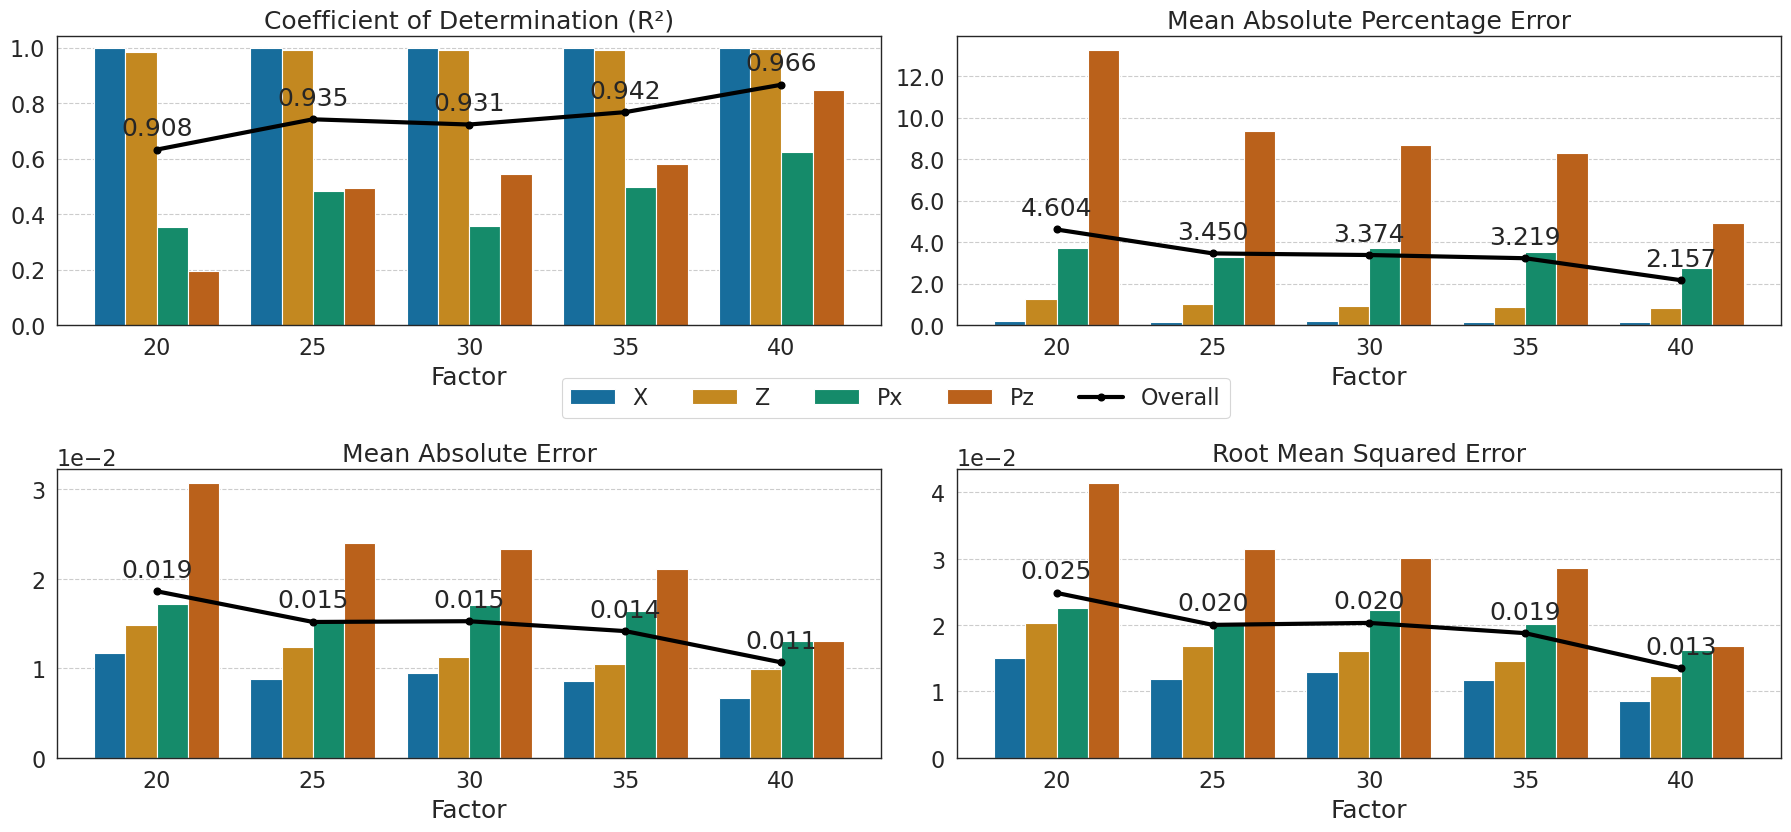

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")
sns.set_context("paper")

metric_title_map = {
    "MAE": "Mean Absolute Error",
    "RMSE": "Root Mean Squared Error",
    "MAPE": "Mean Absolute Percentage Error",
    "R²": "Coefficient of Determination (R²)",
}

df_long = (
    df_test
    .melt(
        id_vars=["metric", "factor"],
        value_vars=["X", "Z", "Px", "Pz", "Overall"],
        var_name="target",
        value_name="value"
    )
)

# Skip MSE metric
filtered_metrics = [m for m in df_long['metric'].unique() if m != 'MSE']
targets = df_long['target'].unique()

# Color palette
palette = sns.color_palette("colorblind", n_colors=len(targets))
color_map = dict(zip(targets, palette))
color_map['Overall'] = 'black'

fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharey=False)

for metric, ax in zip(filtered_metrics, axes.flatten()):
    data = df_long[df_long['metric'] == metric]

    # Plot bars (excluding Overall)
    bar_data = data[data['target'] != 'Overall']
    sns.barplot(
        data=bar_data,
        x='factor',
        y='value',
        hue='target',
        palette=color_map,
        ax=ax,
        dodge=True
    )

    # Prepare Overall line (centered)
    overall_data = data[data['target'] == 'Overall'].sort_values('factor')
    x_vals = overall_data['factor'].unique()
    y_vals = overall_data['value'].values
    
    ax.grid(axis='y', linestyle='--', alpha=1)

    # Convert categorical x-axis positions to numerical centers
    x_ticks = sorted(data['factor'].unique())
    x_pos = [x_ticks.index(x) for x in x_vals]
    

    ax.plot(
        x_pos,
        y_vals,
        color='black',
        marker='o',
        linewidth=3,
        label='Overall',
        zorder=5
    )

    ax.set_title(metric_title_map[metric], fontsize=18)
    ax.set_xlabel("Factor", fontsize=18)
    ax.set_ylabel(None)
    ax.set_xticks(range(len(x_ticks)))
    ax.set_xticklabels(x_ticks, fontsize=16)
    
    y_ticks = ax.get_yticks()
    if metric == 'R²':
        y_ticks = ax.get_yticks()
        y_ticks = [round(tick, 3) for tick in ax.get_yticks()]
        ax.set_yticklabels(y_ticks, fontsize=16)
    elif metric in ['MAE', 'RMSE']:
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
        y_ticks = ax.get_yticks()
        ax.tick_params(axis='y', labelsize=16)            # <-- bars & ticks
        ax.yaxis.get_offset_text().set_fontsize(16)       # <-- the “×10⁻³” offset text
    else:
        ax.set_yticklabels(y_ticks, fontsize=16)

    ax.legend_.remove()
    
    if metric == 'R²':
        ax.set_ylim(0.75, 1.01)
    
    for x, y in zip(x_pos, overall_data['value']):
        y_min, y_max = ax.get_ylim()
        ax.text(x, y + (0.05 * (y_max - y_min)), f"{y:.3f}", ha='center', fontsize=18)

# Custom legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    loc="upper center",
    ncol=len(targets),
    bbox_to_anchor=(0.5, 0.47),
    fontsize=16,
)

# Title and layout
plt.tight_layout()
plt.subplots_adjust(top=0.80, hspace=0.5)
plt.show()

### Analysing the Influence of Subsample Factor in Velocity Field

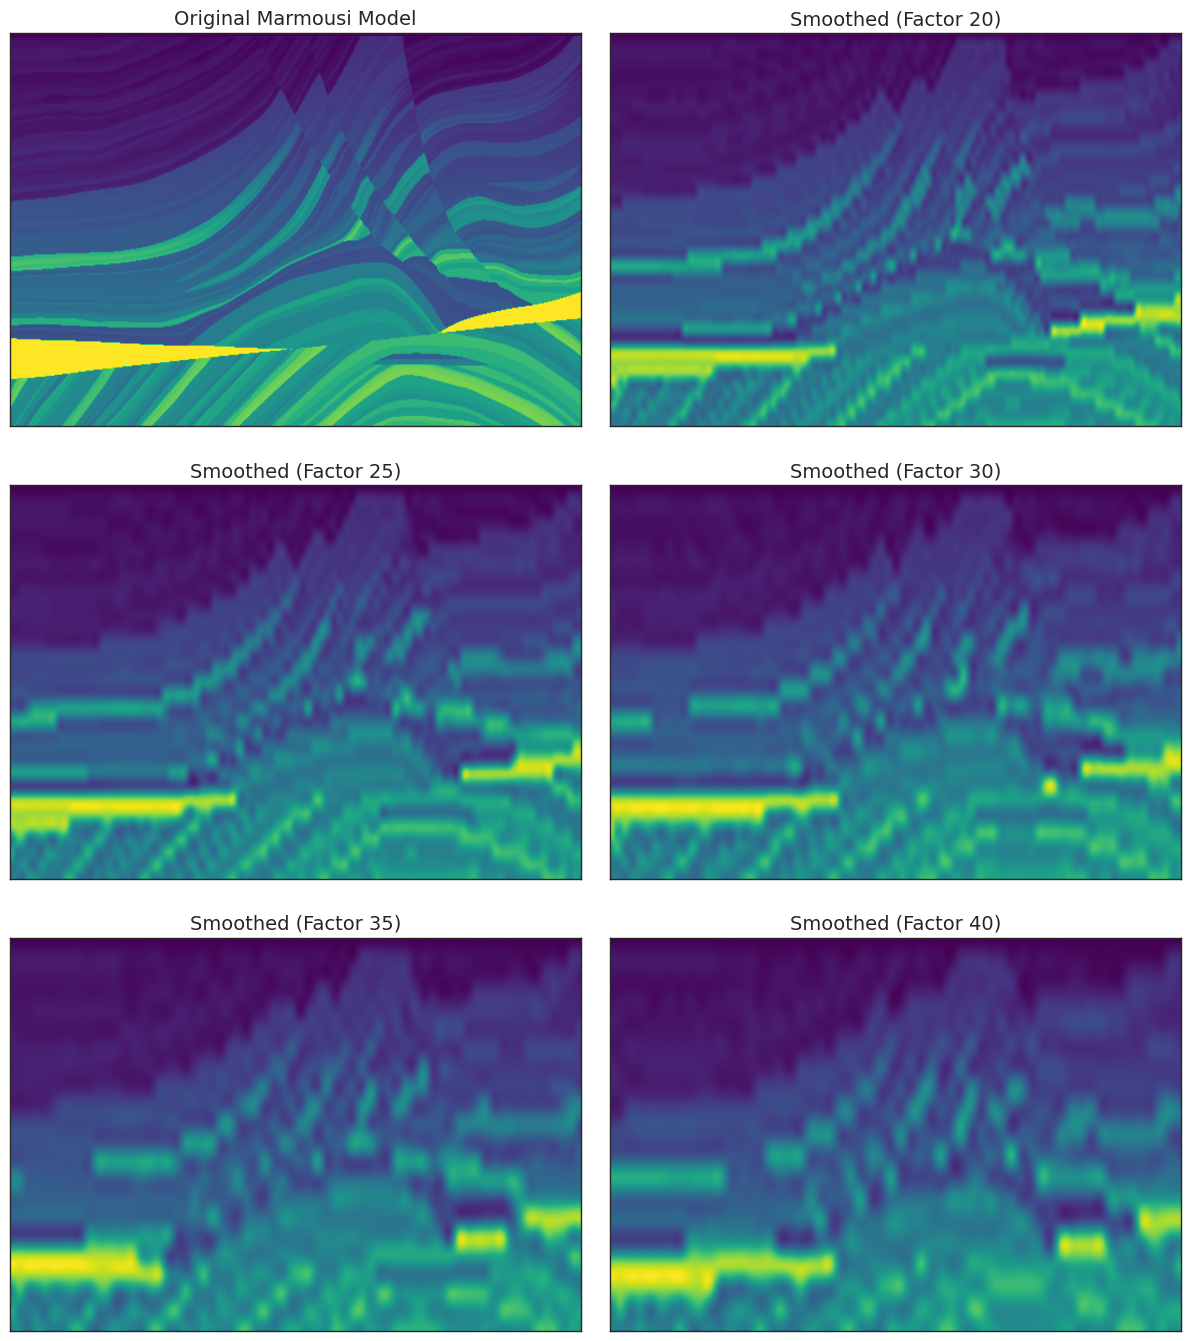

In [103]:
n_factors = len(factor_list)           # how many smoothed models
n_plots   = n_factors + 1              # +1 for the raw Marmousi
n_cols    = 2                          # change to 4, 5, … to suit your taste
n_rows    = math.ceil(n_plots / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(6 * n_cols, 4.5 * n_rows),
    sharex=True, sharey=True
)
axes = axes.flatten()

im = axes[0].imshow(
    vp, extent=[0, xmax, zmax, 0],
    aspect='auto', cmap='viridis'
)
axes[0].set_title("Original Marmousi Model", fontsize=14)
axes[0].set_xticks([])
axes[0].set_yticks([])

for k, factor in enumerate(factor_list, start=1):       # start=1 → panel after Marmousi
    im = axes[k].imshow(
        data_dict[factor]['data_gen'].Vbsplines,
        extent=[0, xmax, zmax, 0],
        aspect='auto', cmap='viridis'
    )
    axes[k].set_title(f"Smoothed (Factor {factor})", fontsize=14)
    axes[k].set_xticks([])
    axes[k].set_yticks([])

plt.tight_layout()

fig.subplots_adjust(wspace=0.05,
                    hspace=0.15)

plt.show()